In [4]:
#!pip install yfinance
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn import preprocessing
import tensorflow as tf
from keras.models import Sequential
import yfinance as yf

# Set random seeds for reproducibility
seed = 2016
np.random.seed(seed)
tf.random.set_seed(seed)

# Splitting into train and test sets
from sklearn.model_selection import train_test_split

# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt

# Splitting into train and test sets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from pmdarima import auto_arima
import pmdarima as pm


In [5]:


def download_litecoin_data():
    # Define the ticker symbol for Litecoin (LTC)
    ticker_symbol = 'LTC-USD'

    # Define the start and end dates for the historical data (5 years ago from the current date)
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(years=5)

    # Download historical data from Yahoo Finance
    data = yf.download(ticker_symbol, start=start_date, end=end_date)

    # Save the data to a CSV file
    data.to_csv('litecoin_data.csv')

if __name__ == "__main__":
    download_litecoin_data()


[*********************100%***********************]  1 of 1 completed


In [6]:
df = pd.read_csv('litecoin_data.csv')

<AxesSubplot:>

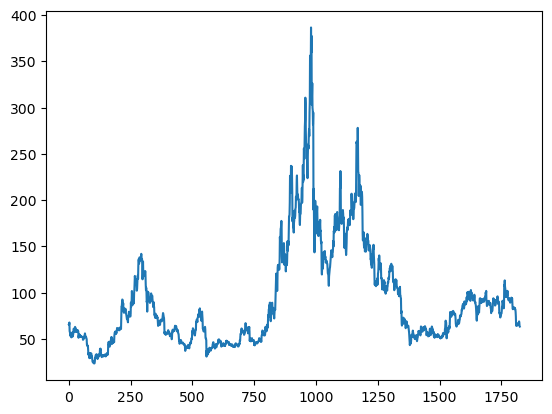

In [7]:
data = df['Adj Close']
data.plot()

In [8]:
# Assuming df is your DataFrame and 'Adj Close' is the column of interest
series = df['Adj Close']

# Perform ADF test
result = adfuller(series)

# Extract results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Statistic: -2.057105915450573
p-value: 0.26210844266365124
Critical Values:
   1%: -3.433968010099092
   5%: -2.8631381499714745
   10%: -2.567620802173316


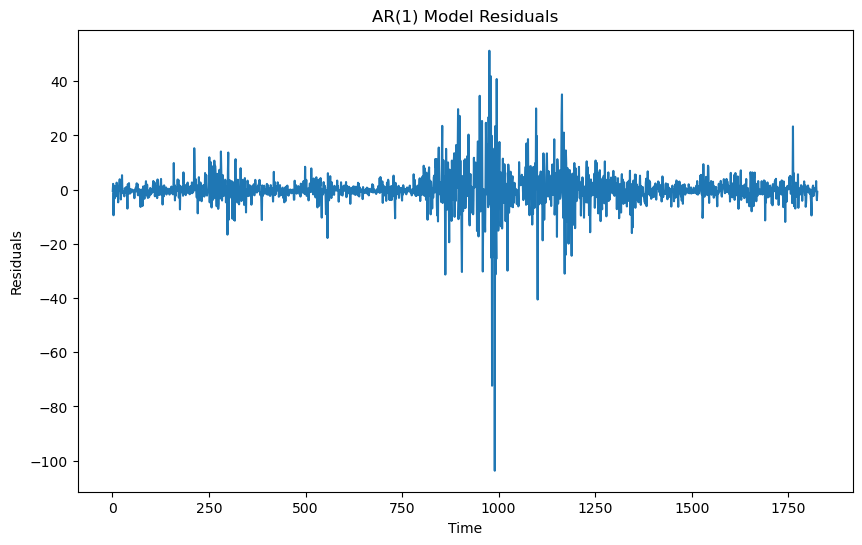

In [9]:
# Create lagged series for AR(1) model
lagged_series = series.shift(1).dropna()

# Fit AR(1) model
model = sm.OLS(series[1:], sm.add_constant(lagged_series))
results = model.fit()

# Get residuals
residuals = results.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('AR(1) Model Residuals')
plt.show()

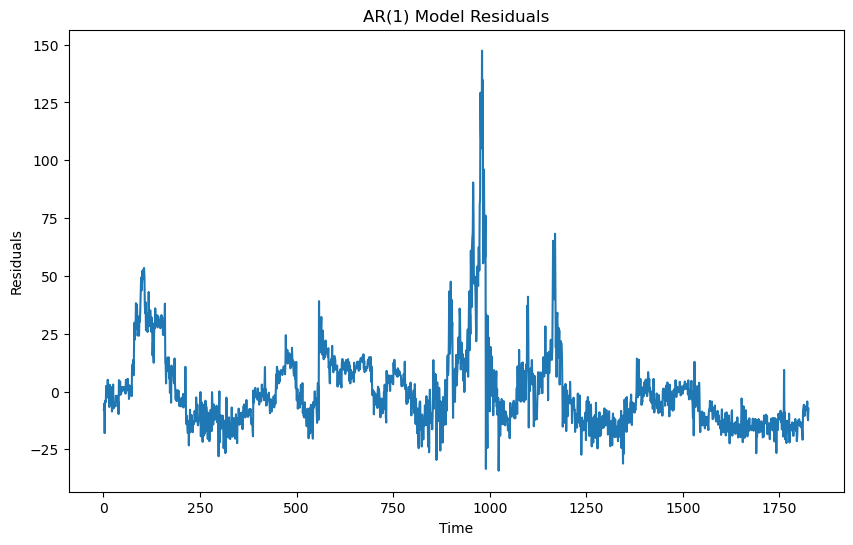

In [10]:
# Apply logarithm to the series
logged_series = np.log(series)

# Create a DataFrame with logged_series and lagged_series
datalog = pd.DataFrame({'Logged_Series': logged_series[1:], 'Lagged_Series': lagged_series})

# Create lagged series for AR(1) model
lagged_series = np.log(series).shift(1).dropna()

# Fit AR(1) model
model = sm.OLS(series[1:], sm.add_constant(lagged_series))
results = model.fit()

# Get residuals
residuals = results.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('AR(1) Model Residuals')
plt.show()

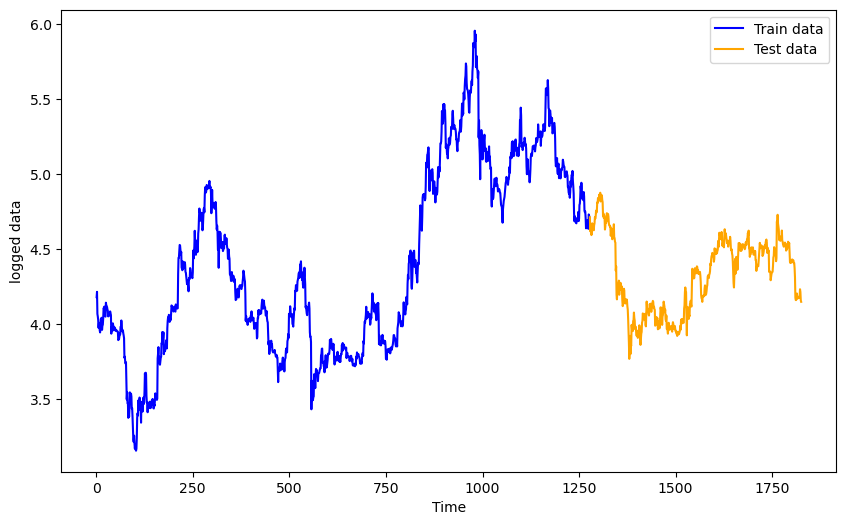

In [11]:

train_size = 0.7
train_data, test_data = train_test_split(datalog.Logged_Series, train_size=train_size, shuffle=False)

# Plot train and test data with different colors
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Train data', color='blue')
plt.plot(test_data.index, test_data, label='Test data', color='orange')
plt.xlabel('Time')
plt.ylabel('logged data')
#plt.title('AR(1) Model Residuals')
plt.legend()
plt.show()

In [12]:
# Apply Hodrick-Prescott filter
cycle, trend = hpfilter(datalog['Logged_Series'], lamb=1000)  # Adjust the lambda parameter as needed

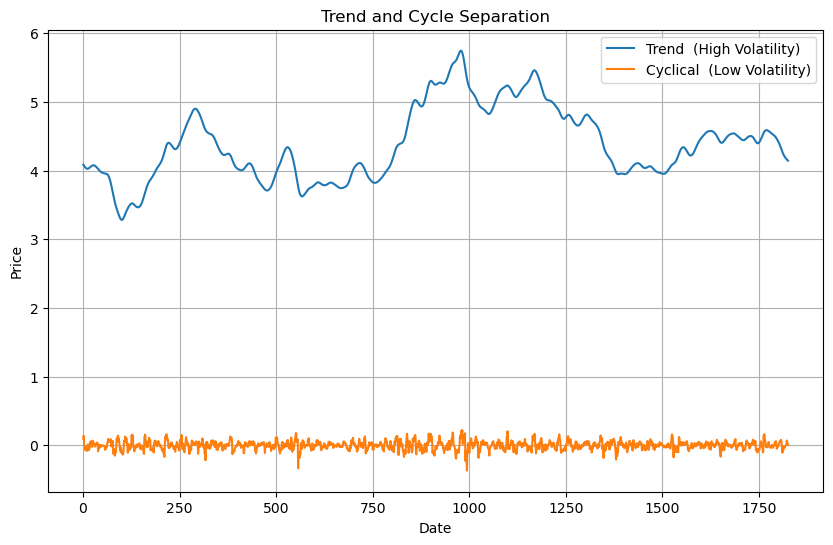

In [13]:



plt.figure(figsize=(10, 6))

# Plot the trend (low volatility)
plt.plot(trend, label='Trend  (High Volatility)')

# Plot the cycle (high volatility)
plt.plot(cycle, label='Cyclical  (Low Volatility)')

# Highlight high and low volatility periods
#plt.scatter(high_volatility_series.index, high_volatility_series,
#            color='red', label='High Volatility Periods')
#plt.scatter(low_volatility_series.index, low_volatility_series,
#            color='green', label='Low Volatility Periods')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Trend and Cycle Separation')
plt.legend()
plt.grid(True)
plt.show()

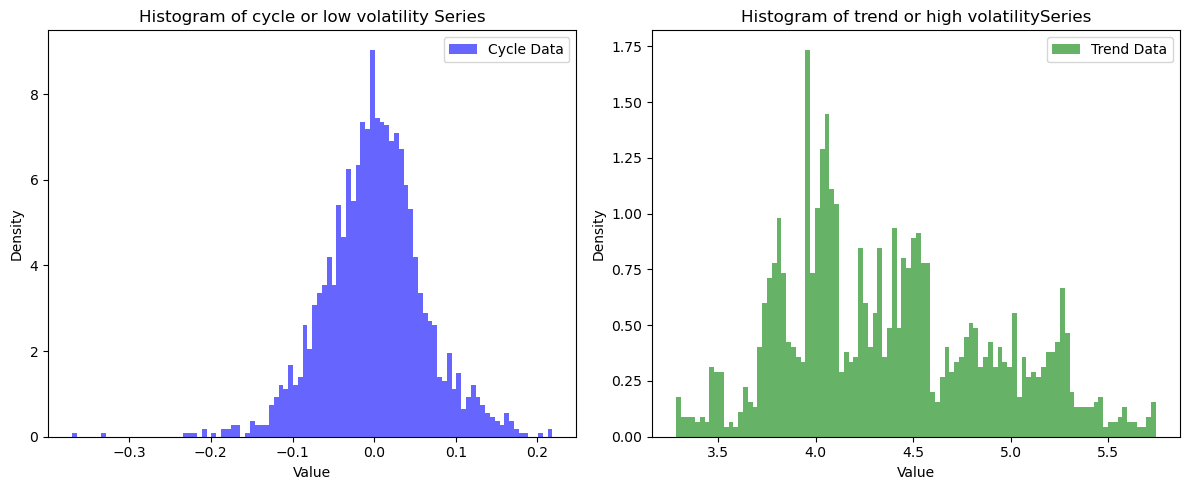

In [62]:
import matplotlib.pyplot as plt

# Create a 1x2 subplot grid
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram of cycle_series in the first subplot
axs[0].hist(cycle, bins=100, density=True, alpha=0.6, color='b', label='Cycle Data')
axs[0].set_title('Histogram of cycle or low volatility Series')

# Plot the histogram of trend_series in the second subplot
axs[1].hist(trend, bins=100, density=True, alpha=0.6, color='g', label='Trend Data')
axs[1].set_title('Histogram of trend or high volatilitySeries')

# Add labels and legend
for ax in axs:
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


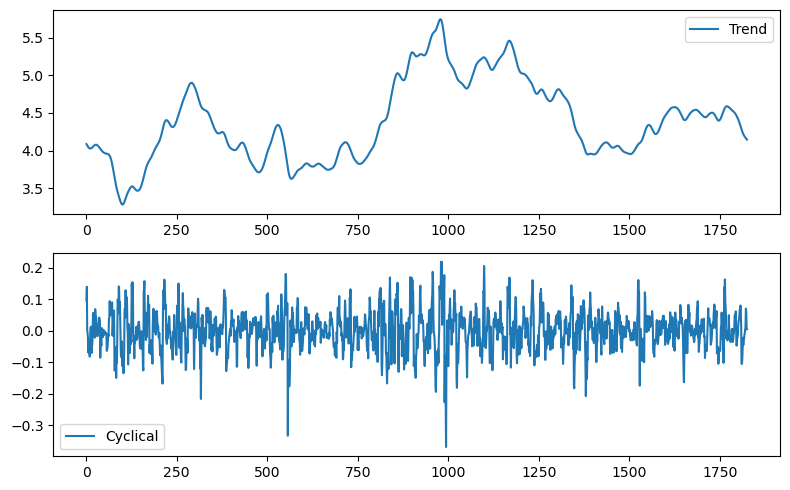

In [14]:
# Reconstruct the original time series using the trend and cyclical components
reconstructed_series = trend + cycle

# Plot the original, reconstructed, trend, and cyclical time series
plt.figure(figsize=(8, 5))
#plt.subplot(411)
#plt.plot(datalog['Logged_Series'], label='Original')
#plt.legend()

#plt.subplot(412)
#plt.plot(reconstructed_series, label='Reconstructed')
#plt.legend()

plt.subplot(211)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(212)
plt.plot(cycle, label='Cyclical')
plt.legend()

plt.tight_layout()
plt.show()

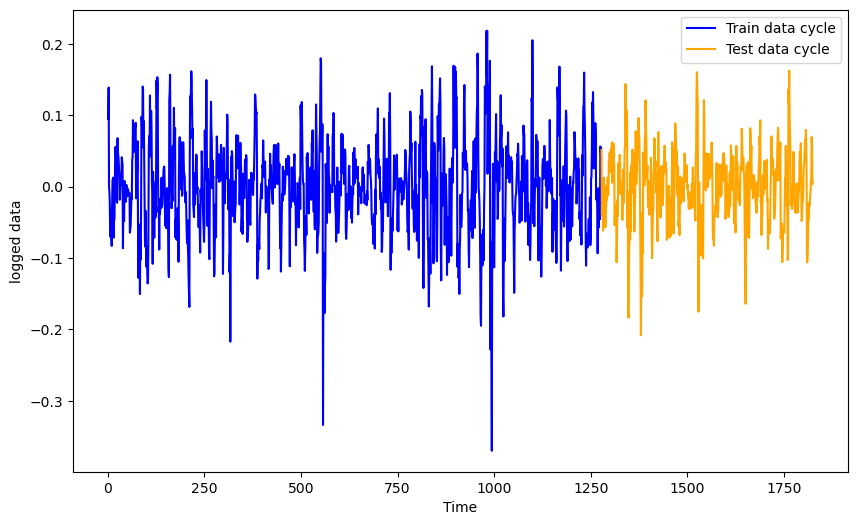

In [15]:

train_size = 0.7
ctrain_data, ctest_data = train_test_split(cycle, train_size=train_size, shuffle=False)

# Plot train and test data with different colors
plt.figure(figsize=(10, 6))
plt.plot(ctrain_data.index, ctrain_data, label='Train data cycle', color='blue')
plt.plot(ctest_data.index, ctest_data, label='Test data cycle', color='orange')
plt.xlabel('Time')
plt.ylabel('logged data')
#plt.title('AR(1) Model Residuals')
plt.legend()
plt.show()

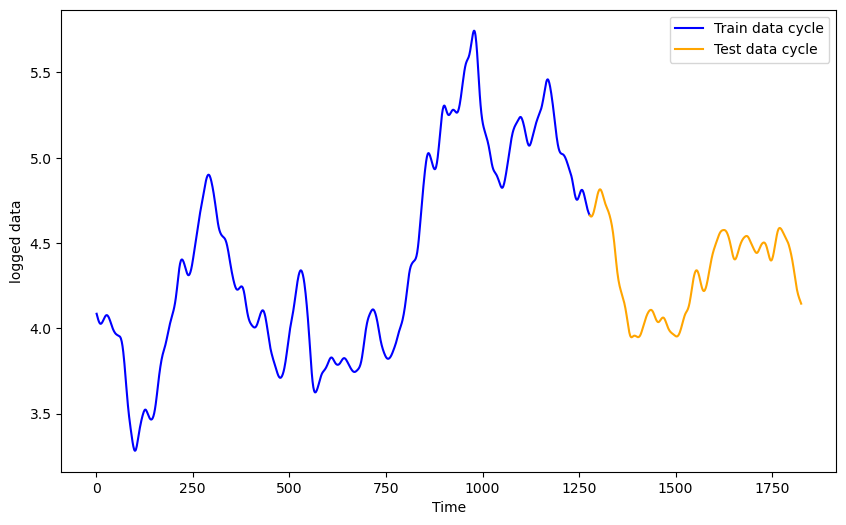

In [16]:

train_size = 0.7
ttrain_data, ttest_data = train_test_split(trend, train_size=train_size, shuffle=False)

# Plot train and test data with different colors
plt.figure(figsize=(10, 6))
plt.plot(ttrain_data.index, ttrain_data, label='Train data cycle', color='blue')
plt.plot(ttest_data.index, ttest_data, label='Test data cycle', color='orange')
plt.xlabel('Time')
plt.ylabel('logged data')
#plt.title('AR(1) Model Residuals')
plt.legend()
plt.show()

In [17]:
traincycle1 = ctrain_data.shift (1)
traincycle2 = ctrain_data.shift (2)
traincycle3 = ctrain_data.shift (3)
traincycle4 = ctrain_data.shift (4)
traincycle5 = ctrain_data.shift (5)

traincycle = pd.concat([ctrain_data, traincycle1, traincycle2, traincycle3, traincycle4, traincycle5], axis=1)

traincycle.columns = ['y', 'df_1', 'df_2', 'df_3', 'df_4', 'df_5']

traincycle = traincycle.dropna()

traincycley = traincycle.y
cols = ['df_1', 'df_2', 'df_3', 'df_4', 'df_5']
traincyclex=traincycle[cols]

In [18]:
scaler_x = preprocessing.MinMaxScaler(feature_range=( -1 , 1))
#import numpy as np
traincyclex = np.array(traincyclex).reshape((len( traincyclex ),5))
traincyclex = scaler_x.fit_transform(traincyclex)

scaler_y = preprocessing.MinMaxScaler(feature_range=( -1 , 1))
#import numpy as np
traincycley = np.array(traincycley).reshape((len( traincycley ),1))
traincycley = scaler_y.fit_transform(traincycley)

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from kerastuner.tuners import RandomSearch

# Define the hyperparameters to search
hyperparameters = {
    'units': [4, 8, 16],
    'activation': ['relu', 'tanh'],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Create a model-building function
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=4, max_value=16, step=4),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(5, 1)))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  metrics=['mse'])
    return model

# Initialize the RandomSearch tuner
tuner = RandomSearch(build_model, objective='val_loss', max_trials=10, directory='tuner_results', project_name='my_tuner')

# Perform the hyperparameter search
tuner.search(traincyclex, traincycley, epochs=10, validation_split=0.2)

# Get the best model's architecture and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model on the full training data
best_model.fit(traincyclex, traincycley, epochs=10)


INFO:tensorflow:Reloading Tuner from tuner_results\my_tuner\tuner0.json


C:\Users\81704\AppData\Local\Temp\ipykernel_13296\1265373867.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


INFO:tensorflow:Oracle triggered exit
Epoch 1/10
40/40 [==============================] - 4s 8ms/step - loss: 0.0299 - mse: 0.0299
Epoch 2/10
40/40 [==============================] - 0s 7ms/step - loss: 0.0283 - mse: 0.0283
Epoch 3/10
40/40 [==============================] - 0s 6ms/step - loss: 0.0282 - mse: 0.0282
Epoch 4/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0263 - mse: 0.0263
Epoch 5/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0262 - mse: 0.0262
Epoch 6/10
40/40 [==============================] - 0s 7ms/step - loss: 0.0260 - mse: 0.0260
Epoch 7/10
40/40 [==============================] - 0s 8ms/step - loss: 0.0258 - mse: 0.0258
Epoch 8/10
40/40 [==============================] - 0s 6ms/step - loss: 0.0259 - mse: 0.0259
Epoch 9/10
40/40 [==============================] - 0s 6ms/step - loss: 0.0253 - mse: 0.0253
Epoch 10/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0254 - mse: 0.0254


In [20]:
# Print the optimal hyperparameters
print("Optimal Hyperparameters:")
print(best_hyperparameters)

# Print the architecture of the best model
print("Best Model Architecture:")
print(best_model.summary())

# Print the weights of the best model's layers
print("Weights of the Best Model:")
for layer in best_model.layers:
    print("Layer Name:", layer.name)
    print("Weights:", layer.get_weights())
    print("---------------------")


Optimal Hyperparameters:
Best Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Weights of the Best Model:
Layer Name: lstm
Weights: [array([[ 0.16747096, -0.24785925,  0.03823641, -0.15181248, -0.12862891,
         0.10922599,  0.18213284,  0.02347675, -0.49809048, -0.31109697,
        -0.05189317,  0.13360234,  0.00257298, -0.18910727, -0.26136518,
        -0.26947904,  0.4304312 , -0.22764426,  0.09356256, -0.05585385,
         0.3711643 

In [21]:
testcycle1 = ctest_data.shift (1)
testcycle2 = ctest_data.shift (2)
testcycle3 = ctest_data.shift (3)
testcycle4 = ctest_data.shift (4)
testcycle5 = ctest_data.shift (5)

In [22]:
testcycle1 = ctest_data.shift (1)
testcycle2 = ctest_data.shift (2)
testcycle3 = ctest_data.shift (3)
testcycle4 = ctest_data.shift (4)
testcycle5 = ctest_data.shift (5)

testcycle = pd.concat([test_data, ctest_data, testcycle1, testcycle2, testcycle3, testcycle4, testcycle5], axis=1)

testcycle.columns = ['yy', 'y', 'df_1', 'df_2', 'df_3', 'df_4', 'df_5']

testcycle = testcycle.dropna()

testcycley = testcycle.y
testcycley2 = testcycle.yy
cols = ['df_1', 'df_2', 'df_3', 'df_4', 'df_5']
testcyclex=testcycle[cols]

In [23]:
scaler_x = preprocessing.MinMaxScaler(feature_range=( -1 , 1))
#import numpy as np
testx = np.array(testcyclex).reshape((len( testcyclex ),5))
testx = scaler_x.fit_transform(testcyclex)

scaler_y = preprocessing.MinMaxScaler(feature_range=( -1 , 1))
#import numpy as np
testcycley = np.array(testcycley).reshape((len( testcycley ),1))
testcycley = scaler_y.fit_transform(testcycley)

In [24]:
score_train = best_model.evaluate(traincyclex, traincyclex , batch_size =1)
score_test = best_model.evaluate(testcyclex, testcycley, batch_size =1)


print(" in train MSE = " , round( score_train[0], 4))
print(" in test MSE = " , round( score_test[0] ,4))


543/543 [==============================] - 2s 3ms/step - loss: 0.0639 - mse: 0.0639
 in train MSE =  0.0461
 in test MSE =  0.0639


In [25]:
predcycle = best_model.predict(testcyclex)
predcycle = scaler_y.inverse_transform(np.array(predcycle).reshape((len( predcycle ),1)))

17/17 [==============================] - 1s 4ms/step


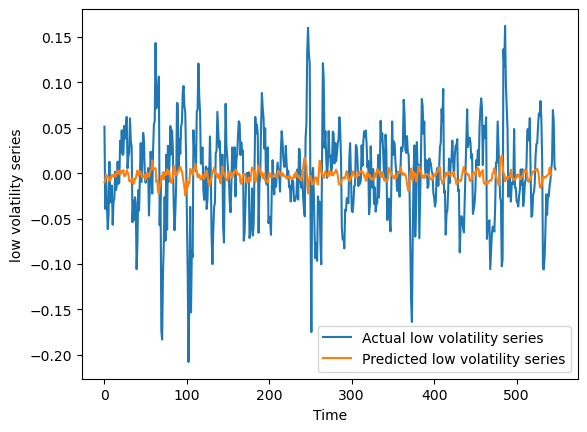

In [63]:
# Assuming ytest and pred1 are Pandas Series or NumPy arrays
# You can convert them to arrays using: ytest.values and pred1.values
plt.plot(ctest_data.values, label='Actual low volatility series')
plt.plot(predcycle, label='Predicted low volatility series')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('low volatility series')
plt.legend()

# Show the plot
plt.show()

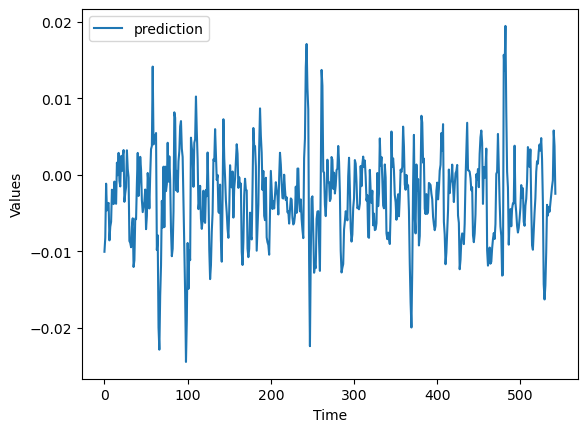

In [26]:
# Assuming ytest and pred1 are Pandas Series or NumPy arrays
# You can convert them to arrays using: ytest.values and pred1.values
#plt.plot(testcycley2.values, label='(raw data)')
plt.plot(predcycle, label='prediction')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

In [27]:
traintrend1 = ttrain_data.shift (1)
traintrend2 = ttrain_data.shift (2)
traintrend3 = ttrain_data.shift (3)
traintrend4 = ttrain_data.shift (4)
traintrend5 = ttrain_data.shift (5)

traintrend = pd.concat([ttrain_data, traintrend1, traintrend2, traintrend3, traintrend4, traintrend5], axis=1)

traintrend.columns = ['y', 'df_1', 'df_2', 'df_3', 'df_4', 'df_5']

traintrend = traintrend.dropna()

traintrendy = traintrend.y
cols = ['df_1', 'df_2', 'df_3', 'df_4', 'df_5']
traintrendx=traintrend[cols]

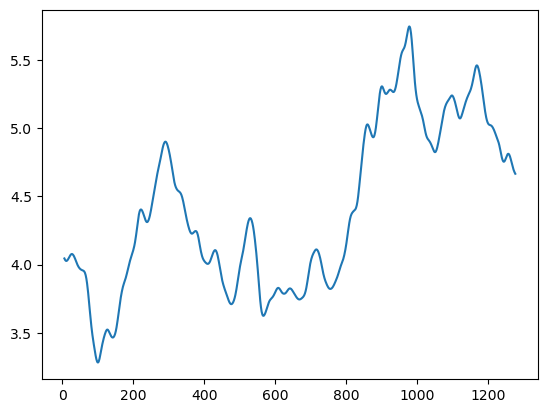

In [28]:
plt.plot(traintrendy)

In [29]:
# Shifting and creating lagged features for the trend component in test_data
testtrend1 = ttest_data.shift(1)
testtrend2 = ttest_data.shift(2)
testtrend3 = ttest_data.shift(3)
testtrend4 = ttest_data.shift(4)
testtrend5 = ttest_data.shift(5)

# Concatenating the lagged features into a DataFrame for test_data
testtrend = pd.concat([ttest_data, testtrend1, testtrend2, testtrend3, testtrend4, testtrend5], axis=1)

# Renaming columns in the testtrend DataFrame
testtrend.columns = ['y', 'df_1', 'df_2', 'df_3', 'df_4', 'df_5']

# Dropping rows with missing values (NaN)
testtrend = testtrend.dropna()

# Separating the target variable (y) and feature columns for test_data
testtrendy = testtrend.y
cols = ['df_1', 'df_2', 'df_3', 'df_4', 'df_5']
testtrendx = testtrend[cols]

In [30]:
# Initialize model
model = auto_arima(traintrendy, max_p=3, max_q=3, seasonal=False, trace=True,
                       error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-18331.360, Time=5.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7778.145, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7777.784, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13588.710, Time=1.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-19571.135, Time=3.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13590.703, Time=1.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-17445.553, Time=4.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21457.057, Time=1.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-21458.955, Time=0.96 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=inf, Time=0.76 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-17447.626, Time=2.69 sec
 ARIMA(2,1,1)(0,0,0)[0]            

In [31]:
# Determine model parameters
model.fit(traintrendy)
order = model.get_params()['order']
print('ARIMA order:', order, '\n')

ARIMA order: (3, 1, 0) 



In [32]:
testtrendy_list = testtrendy.tolist()
traintrendy_list = traintrendy.tolist()

In [33]:
# Genereate predictions
prediction = []
for i in range(len(testtrendy_list)):
    model = pm.ARIMA(order=order)
    model.fit(traintrendy_list)
    test_len = len(testtrendy_list)
    #print('working on', i+1, 'of', test_len, '-- ' + str(int(100 * (i + 1) / test_len)) + '% complete')
    prediction.append(model.predict()[0])
    traintrendy_list.append(testtrendy_list[i])

    # Generate error data
# Generate error data
mse = mean_squared_error(testtrendy_list, prediction)
rmse = mse ** 0.5

C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\81704\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [34]:
def mean_absolute_percentage_error(actual, prediction):
    global actual2, prediction2 #, test, model, order, scaler, x_train, y_train, x_test, i, lstm_len
    actual = pd.Series(actual)
    prediction = pd.Series(prediction)
    prediction2 = prediction.copy()
    actual2 = actual.copy()
    return 100 * np.mean(np.abs((actual - prediction))/actual)

mape = mean_absolute_percentage_error(pd.Series(testtrendy_list), pd.Series(prediction))

In [35]:
print(mse)
print(rmse)
print(mape)

8.303644565511914e-07
0.0009112433574798729
0.004756251745398464


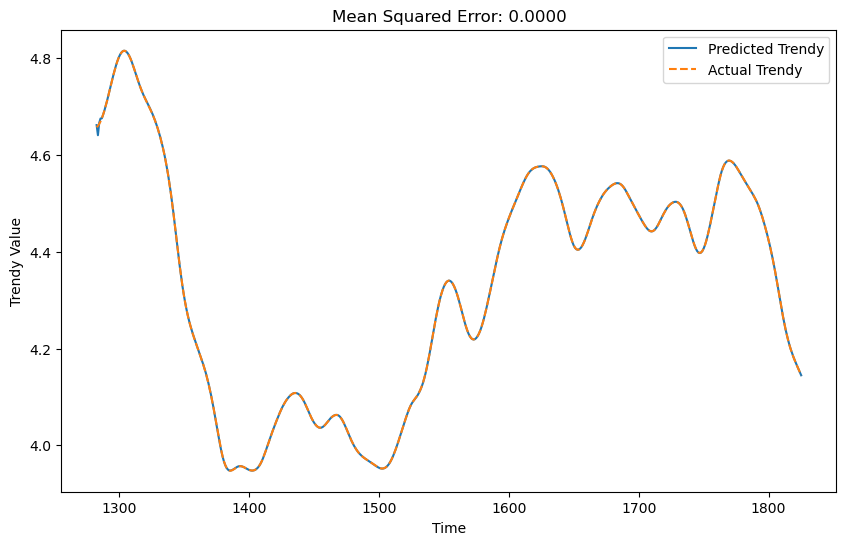

Mean Squared Error: 0.0000


In [36]:
plt.figure(figsize=(10, 6))
plt.plot(testtrendy.index, prediction, label='Predicted Trendy')
plt.plot(testtrendy.index, testtrendy_list, label='Actual Trendy', linestyle='--')


plt.xlabel('Time')
plt.ylabel('Trendy Value')
plt.legend()
plt.title(f'Mean Squared Error: {mse:.4f}')
plt.show()

print(f"Mean Squared Error: {mse:.4f}")

## Using linear regression instead of Arima

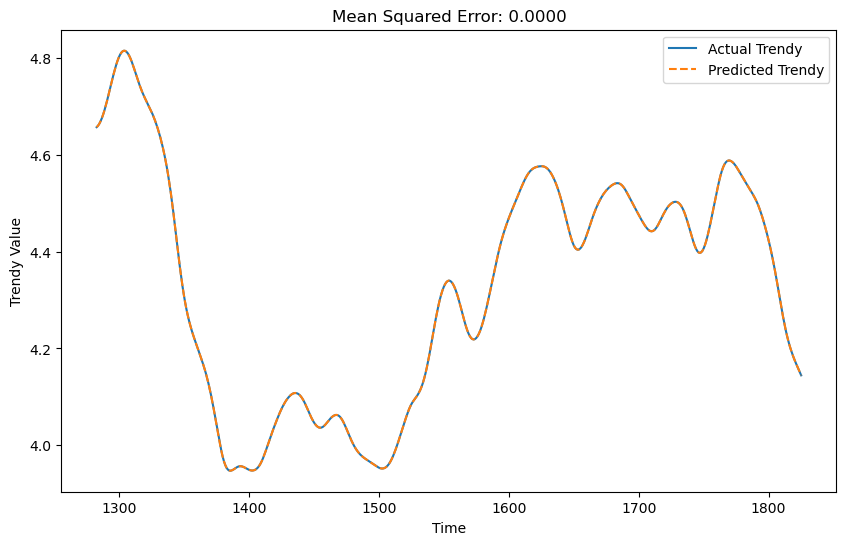

Mean Squared Error: 0.0000


In [37]:
# Assuming traintrendy and testtrendx are already defined
# Train linear regression model
regressor = LinearRegression()
regressor.fit(traintrendx, traintrendy)

# Predict output using testtrendx
predicted_output = regressor.predict(testtrendx)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(testtrendy, predicted_output)

# Plot the predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(testtrendy.index, testtrendy, label='Actual Trendy')
plt.plot(testtrendy.index, predicted_output, label='Predicted Trendy',linestyle='--')
plt.xlabel('Time')
plt.ylabel('Trendy Value')
plt.legend()
plt.title(f'Mean Squared Error: {mse:.4f}')
plt.show()

print(f"Mean Squared Error: {mse:.4f}")

In [38]:
# Create two example arrays
array1 = np.array(predicted_output)
array2 = np.array(predcycle)

In [39]:
#(array2) 
array2_list = np.array(array2).flatten()

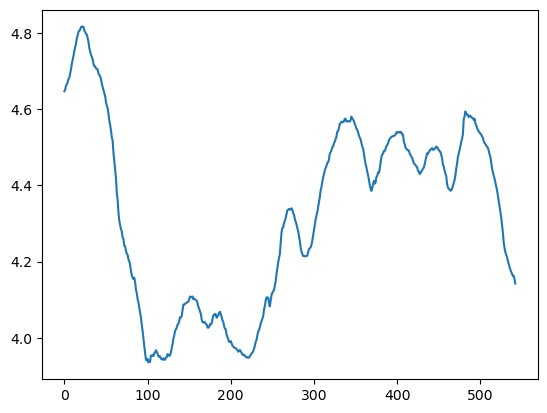

In [40]:
# Add arrays component by component
sum_array = array1 + array2_list

plt.plot(sum_array)

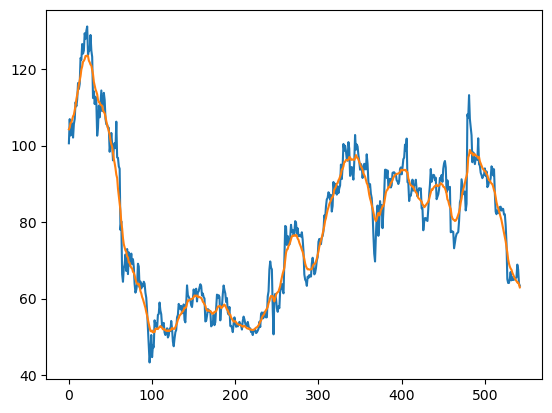

In [41]:
plt.plot(np.exp(testcycley2.values))
plt.plot(np.exp(sum_array))

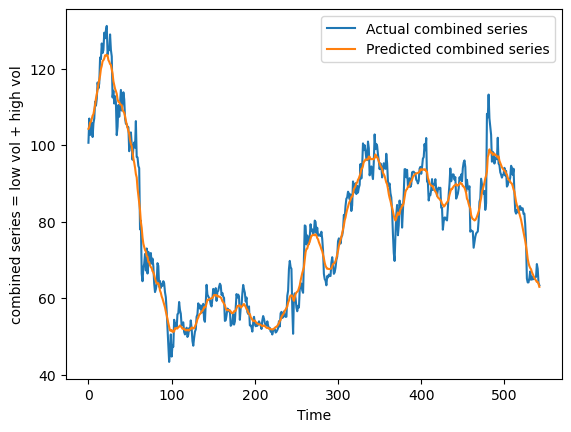

In [64]:
plt.plot(np.exp(testcycley2.values), label='Actual combined series')
plt.plot(np.exp(sum_array),  label='Predicted combined series')
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('combined series = low vol + high vol')
plt.legend()
#plt.plot(ctest_data.values, label='Actual low volatility series')
#plt.plot(predcycle, label='Predicted low volatility series')

In [45]:
#import numpy as np

# Assuming ytest.values and pred1 are NumPy arrays of the same length
ytest_values = np.exp(testcycley2.values)
pred1_values = np.exp(sum_array)

# Initialize variables for positions and capital
capital = 1  # Initial capital in USD
position = 0     # 0: no position, 1: long (buy), -1: short (sell)
initcapital = 1
# Initialize lists to track transactions and capital over time
transactions = []
capital_over_time = [capital]
pricedifference = []
# Backtest strategy
for i in range(len(ytest_values) - 1):
    if pred1_values[i + 1] > ytest_values[i]:
        # Buy if prediction for next time step is greater than actual and no existing long position
        position = 1
        buy_price = ytest_values[i]
        capital = capital * (1 + (ytest_values[i + 1] - buy_price) / buy_price)
        capital_over_time.append(capital)
        kk = pred1_values[i + 1] - ytest_values[i]
        pricedifference.append(kk)
        transactions.append(('Buy', pred1_values[i + 1], ytest_values[i], ytest_values[i+1], ytest_values[i+1]-ytest_values[i], capital_over_time[-1]))
    elif pred1_values[i + 1] < ytest_values[i]:
        # Sell if prediction for next time step is less than actual and no existing short position
        position = -1
        sell_price = ytest_values[i]
        capital = capital * (1 - (ytest_values[i + 1] - sell_price) / sell_price)
        capital_over_time.append(capital)
        kk = pred1_values[i + 1] - ytest_values[i]
        pricedifference.append(kk)
        transactions.append(('Sell', pred1_values[i + 1], ytest_values[i], ytest_values[i+1], ytest_values[i+1]-ytest_values[i], capital_over_time[-1]))
    else:
        # Hold (do nothing)
        transactions.append(('Hold', None))
        pricedifference.append(('Hold', None))

    # Calculate capital after each transaction
    #if position == 1:
    #    capital = capital * (1 + (ytest_values[i + 1] - buy_price) / buy_price)
    #elif position == -1:
    #    capital = capital * (1 - (ytest_values[i + 1] - sell_price) / sell_price)

    

# Calculate final profit or return
profit = capital - initcapital  # Profit is the final capital minus the initial capital

print(f"Final capital: ${capital:.2f}")
print(f"Profit: ${profit:.2f}")

Final capital: $954.15
Profit: $953.15


In [46]:
import numpy as np

# Assuming ytest.values and pred1 are NumPy arrays of the same length
ytest_values = np.exp(testcycley2.values)
pred1_values = np.exp(sum_array)

# Initialize variables for positions and capital
capital = 1  # Initial capital in USD
position = 0     # 0: no position, 1: long (buy), -1: short (sell)
initcapital = 1
# Initialize lists to track transactions and capital over time
transactions = []
capital_over_time = [capital]
pricedifference = []
returns = []  # List to track returns at each iteration
# Backtest strategy
for i in range(len(ytest_values) - 1):
    if pred1_values[i + 1] > ytest_values[i]:
        # Buy if prediction for next time step is greater than actual and no existing long position
        position = 1
        buy_price = ytest_values[i]
        return_at_iteration = (ytest_values[i + 1] - buy_price) / buy_price  # Calculate return at this iteration
        capital = capital * (1 + (ytest_values[i + 1] - buy_price) / buy_price)
        #capital = capital * (1 + return_at_iteration)
        capital_over_time.append(capital)
        kk = pred1_values[i + 1] - ytest_values[i]
        pricedifference.append(kk)        
        transactions.append(('Buy', pred1_values[i + 1], ytest_values[i], ytest_values[i+1], return_at_iteration, capital_over_time[-1]))
    elif pred1_values[i + 1] < ytest_values[i]:
        # Sell if prediction for next time step is less than actual and no existing short position
        position = -1
        sell_price = ytest_values[i]
        return_at_iteration = -1*(ytest_values[i + 1] - sell_price) / sell_price  # Calculate return at this iteration
        capital = capital * (1 - (ytest_values[i + 1] - sell_price) / sell_price)
        #capital = capital * (1 + return_at_iteration)
        capital_over_time.append(capital)
        kk = pred1_values[i + 1] - ytest_values[i]
        pricedifference.append(kk)
        transactions.append(('Sell', pred1_values[i + 1], ytest_values[i], ytest_values[i+1], return_at_iteration, capital_over_time[-1]))
    else:
        # Hold (do nothing)
        transactions.append(('Hold', None))
        pricedifference.append(('Hold', None))
    
    # Append return at this iteration to the returns list
    returns.append(return_at_iteration)  # Multiply by 100 to get percentage return

# Calculate final profit or return
profit = capital - initcapital  # Profit is the final capital minus the initial capital

print(f"Final capital: ${capital:.2f}")
print(f"Profit: ${profit:.2f}")


Final capital: $954.15
Profit: $953.15


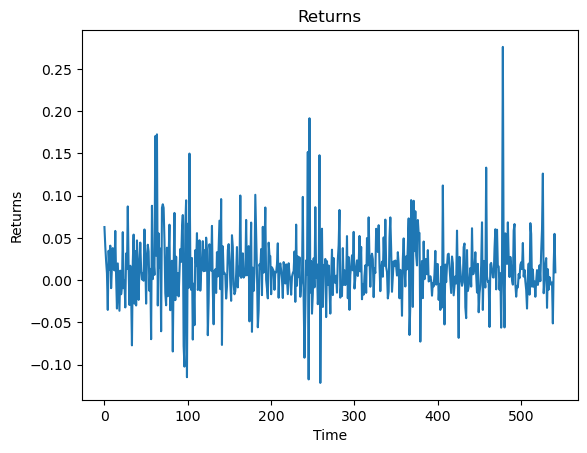

In [55]:
plt.plot(returns)
plt.xlabel('Time')
plt.ylabel('Returns')
#plt.legend()
plt.title('Returns')
plt.show()

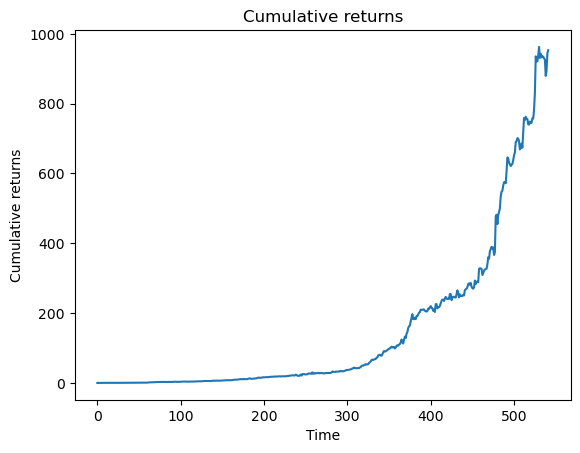

In [60]:
cumulative_return = np.cumprod(1 + np.array(returns)) - 1
plt.plot(cumulative_return)
plt.xlabel('Time')
plt.ylabel('Cumulative returns')
#plt.legend()
plt.title('Cumulative returns')
plt.show()

In [49]:
import pandas as pd
import numpy as np


# Convert the NumPy array into a DataFrame
df = pd.DataFrame({'Stock_Price': ytest_values})
df['predicted_price'] = pred1_values

# Compute the previous price and add it to the DataFrame
df['Previous_Price'] = df['Stock_Price'].shift(1)

# Print the DataFrame
print(df)

     Stock_Price  predicted_price  Previous_Price
0     100.617645       104.263761             NaN
1     106.942093       104.746471      100.617645
2     102.655510       105.910175      106.942093
3     104.965355       106.092697      102.655510
4     105.832397       106.873661      104.965355
..           ...              ...             ...
538    65.542503        64.570848       65.367111
539    68.892471        64.222035       65.542503
540    67.659531        64.243036       68.892471
541    63.951378        63.715790       67.659531
542    63.352364        62.934366       63.951378

[543 rows x 3 columns]


In [50]:
df.head()

,Stock_Price,predicted_price,Previous_Price
0,100.617645,104.263761,NaN
1,106.942093,104.746471,100.617645
2,102.655510,105.910175,106.942093
3,104.965355,106.092697,102.655510
4,105.832397,106.873661,104.965355


In [51]:
# Calculate deltaYF
# deltaYF = yF - np.roll(y, 1)
deltaYF = df.predicted_price - df.Previous_Price

deltaYF[0] = 0  # Set the first element to 0 since there's no y at t-1 for the first element

# Trading strategy
pos = np.zeros_like(df.Previous_Price)
pos[deltaYF > 0] = 1
pos[deltaYF < 0] = -1

import numpy as np

def backshift(day, x):
    assert day >= 0
    y = np.concatenate((np.full(day, np.nan), x[:-day]))
    return y

# Apply backshift with day=1
result = backshift(1, pos)

#print("Original 'pos' array:")
#print(pos)

#print("\nResult after backshift(1, pos):")
#print(result)

y = df.Previous_Price

# Calculate returns 
ret = backshift(1, pos) * (y - backshift(1, y)) /backshift(1, y)
ret[0] = 0  # Replace the NaN at the first position with 0

# Assuming 'ret' is a NumPy array in Python
ret[np.isnan(ret)] = 0
cumret = np.cumprod(1 + ret) - 1

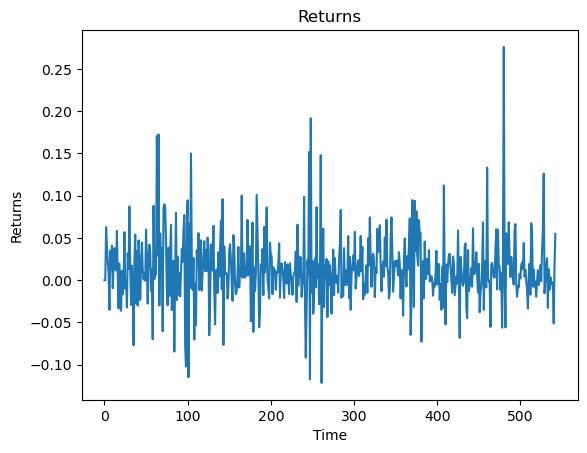

In [56]:
plt.plot(ret)
plt.xlabel('Time')
plt.ylabel('Returns')
#plt.legend()
plt.title('Returns')
plt.show()

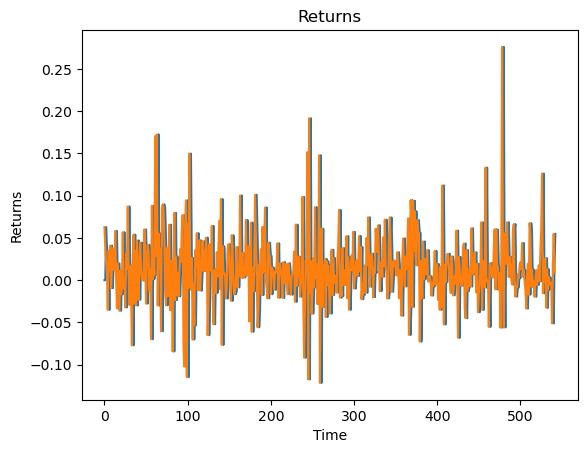

In [57]:
plt.plot(ret)
plt.plot(returns)
plt.xlabel('Time')
plt.ylabel('Returns')
#plt.legend()
plt.title('Returns')
plt.show()

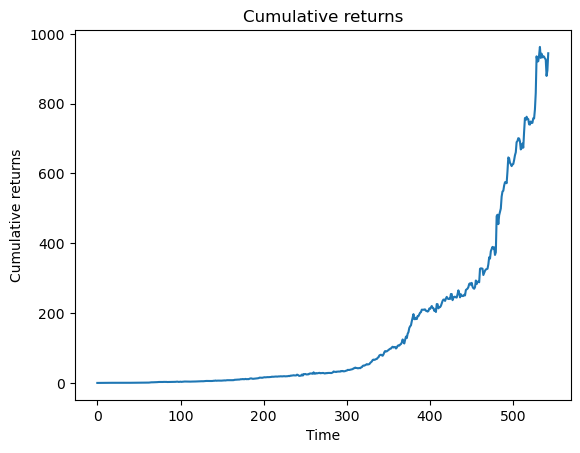

In [59]:
plt.plot(cumret)
plt.xlabel('Time')
plt.ylabel('Cumulative returns')
#plt.legend()
plt.title('Cumulative returns')
plt.show()